In [ ]:
# imports
!pip install pyyaml

# PyTorch 1.10 + cuda 11.1
# https://pytorch.org/get-started/previous-versions/
!pip uninstall torch torchvision -y
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Detectron2 built for PyTorch 1.10 + cuda 11.1
# https://detectron2.readthedocs.io/en/latest/tutorials/install.html
!pip uninstall detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

In [ ]:
# check pytorch installation:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.10")   # please manually install torch 1.10 if Colab changes its default version

1.10.1+cu111 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Dataset with basketball players (2 teams)

- download it
- prepare it for Detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
dataset_path = root_dir + "datasets/otus_basketball_dataset.zip"
!cp "$dataset_path" .
!unzip otus_basketball_dataset.zip > /dev/null

Mounted at /content/gdrive


In [ ]:
from detectron2.structures import BoxMode

def get_bteam_dicts(dataset_dir, mode_str):
    json_file = os.path.join(dataset_dir, f"anno_{mode_str}.json")
    img_dir = os.path.join(dataset_dir, f"images_{mode_str}")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, (file_name, v) in enumerate(imgs_anns.items()):
        record = {}

        filename = os.path.join(img_dir, file_name)
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v
        objs = []
        for _, anno in annos.items():
            x, y, w, h = anno["box"]
            x *= width
            y *= height
            w *= width
            h *= height
            obj = {
                "bbox": [x, y, w, h],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": anno["team"],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
all_dataset_dicts = {mode_str: get_bteam_dicts("otus_basketball_dataset/", mode_str) for mode_str in ("train", "test")}

In [ ]:
for mode_str in ["train", "test"]:
    DatasetCatalog.register("bteam_" + mode_str, lambda mode_str=mode_str: get_bteam_dicts("otus_basketball_dataset/", mode_str))
    MetadataCatalog.get("bteam_" + mode_str).set(thing_classes=["team1", "team2"])
bteam_metadata = MetadataCatalog.get("bteam_train")

### Visualize some images

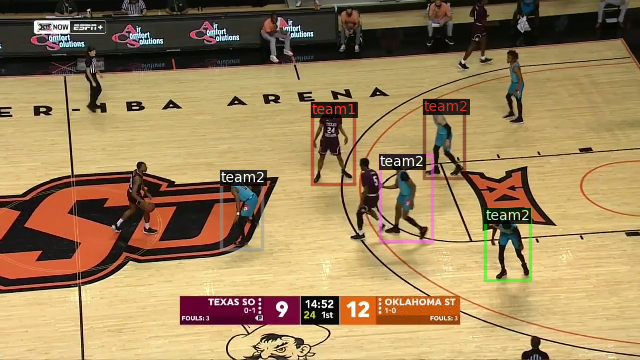

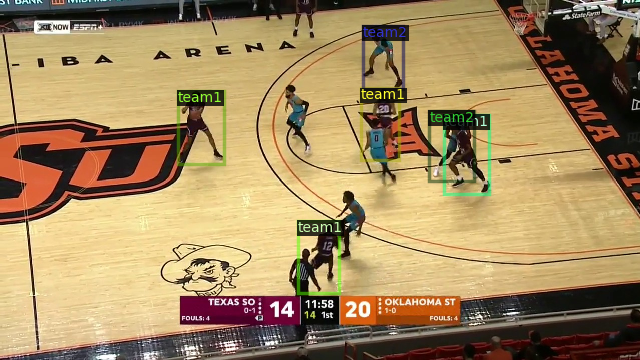

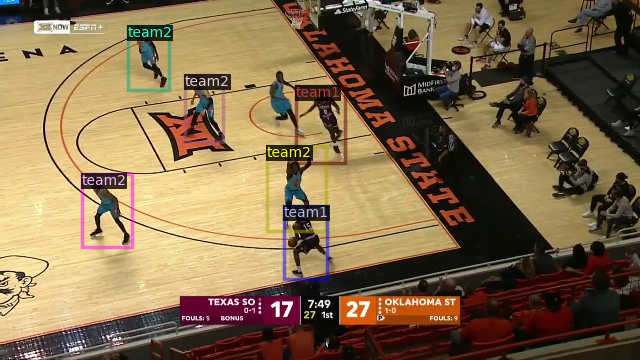

In [ ]:
dataset_dicts = all_dataset_dicts["train"]
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bteam_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

#### Train Model faster_rcnn_R_50_FPN on basketball dataset

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("bteam_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0004
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/23 10:16:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:01, 114MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/23 10:16:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.9/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/23 10:17:07 d2.utils.events]:  eta: 0:07:25  iter: 19  total_loss: 2.09  loss_cls: 1.115  loss_box_reg: 0.8207  loss_rpn_cls: 0.1093  loss_rpn_loc: 0.03787  time: 0.4432  data_time: 0.0311  lr: 7.9924e-06  max_mem: 2641M
[04/23 10:17:16 d2.utils.events]:  eta: 0:07:28  iter: 39  total_loss: 2.001  loss_cls: 1.058  loss_box_reg: 0.8154  loss_rpn_cls: 0.09556  loss_rpn_loc: 0.03647  time: 0.4611  data_time: 0.0143  lr: 1.5984e-05  max_mem: 2641M
[04/23 10:17:26 d2.utils.events]:  eta: 0:07:29  iter: 59  total_loss: 1.873  loss_cls: 0.9393  loss_box_reg: 0.7962  loss_rpn_cls: 0.1046  loss_rpn_loc: 0.03085  time: 0.4676  data_time: 0.0111  lr: 2.3976e-05  max_mem: 2641M
[04/23 10:17:35 d2.utils.events]:  eta: 0:07:22  iter: 79  total_loss: 1.713  loss_cls: 0.8117  loss_box_reg: 0.7942  loss_rpn_cls: 0.07989  loss_rpn_loc: 0.03262  time: 0.4684  data_time: 0.0096  lr: 3.1968e-05  max_mem: 2641M
[04/23 10:17:45 d2.utils.events]:  eta: 0:07:14  iter: 99  total_loss: 1.67  loss_cls: 0.7157

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

### Look at prediction

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.9/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


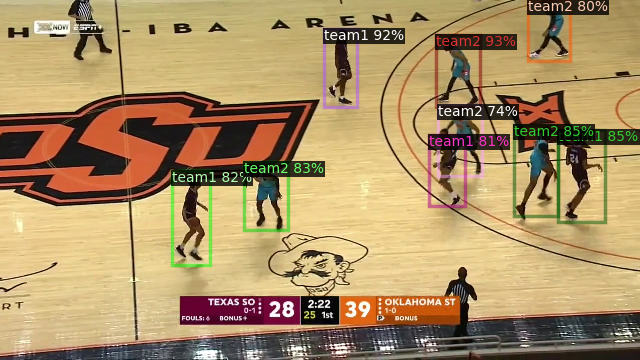

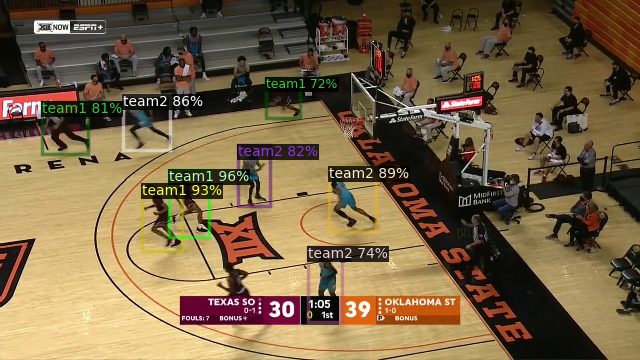

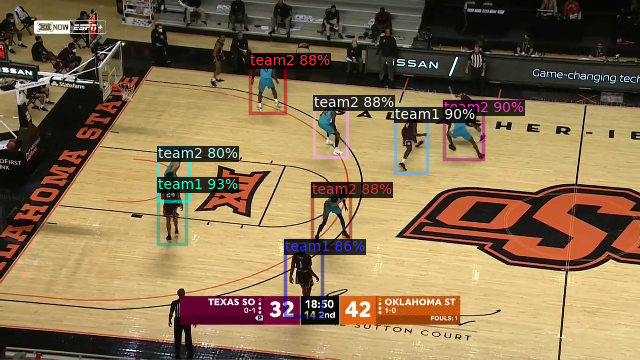

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = all_dataset_dicts["test"]
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=bteam_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

### Calculate AP

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bteam_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "bteam_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

[04/23 10:25:57 d2.evaluation.coco_evaluation]: Trying to convert 'bteam_test' to COCO format ...
[04/23 10:25:57 d2.data.datasets.coco]: Converting annotations of dataset 'bteam_test' to COCO format ...)
[04/23 10:25:58 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/23 10:25:58 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 660
[04/23 10:25:58 d2.data.datasets.coco]: Caching COCO format annotations at './output/bteam_test_coco_format.json' ...
[04/23 10:26:00 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   team1    | 377          |   team2    | 283          |
|            |              |            |              |
|   total    | 660          |            |              |
[04/23 10:26:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(8